In [26]:
%matplotlib inline

import sys
import collections
import itertools
import functools
import urllib3

from elasticsearch import Elasticsearch
from collections import defaultdict, Hashable
from functools import total_ordering, reduce
from abc import abstractmethod, ABCMeta

import numpy as np
import pandas as pd
import networkx as nx

from linkalytics.environment import cfg
from linkalytics.utils import memoize
from elasticsearch_dsl.connections import connections
from elasticsearch_dsl.search import Search
from elasticsearch_dsl.query import Q, Ids

urllib3.disable_warnings()

# Factor Network Functions

# Messenger Class

Performs transformations on data.

    eg. f(x) -> y
    
Decoupled from the other factor network code, and can be swapped with other implementations

In [27]:
class Messenger:

    def __init__(self, config='cdr', size=2000):
        """
        :param url: str
            Fully qualified url to an elasticsearch instance
        :param size: int|
            Size limit to set on elasticsearch query
        """
        self.conn = connections.get_connection(config)
        self.elastic = Search('cdr', extra={'size': size})
    
    def match(self, match_type, **kwargs):
        return self.elastic.query(match_type, **kwargs).execute()
    
    @memoize
    def available(self, ad_id):
        """
        Get's the available factors for a particular ad

        :param ad_id: str
            Unique ad identifier

        :return: factors
        :rtype : list
        """
        accumulator = lambda x,y: x|y
        output      = self.match('match_phrase', _id=ad_id)
        keys        = [
            set(i['_source'].keys())
                for i in output.hits.hits
        ]
        return list(reduce(accumulator, keys, set()))

    def lookup(self, ad_id, field):
        """
        Get data from ad_id

        :param ad_id: str
            String to be queried
        """
        if not isinstance(ad_id, list):
            ad_id = [ad_id]

        results = self.elastic.query(Ids(values=ad_id)).execute()
        
        return set(flatten([
            hits['_source'][field] for hits in results.hits.hits
                if field in hits['_source']
        ]))

    def reverse_lookup(self, field, field_value):
        """
        Get ad_id from a specific field and search term

        :param field_value: str
            String to be queried
        """
        results = self.match(
            'match_phrase', **{field:field_value}).hits.hits

        if not results:
            results = self.match('match', _all=field_value).hits.hits

        return [hit['_id'] for hit in results]

    def suggest(self, ad_id, field):
        """
        The suggest function suggests other ad_ids that share this
        field with the input ad_id.
        """
        suggestions = {}
        field_values = self.lookup(ad_id, field)

        for value in field_values:
            ads = set(self.reverse_lookup(field, value))

            # To prevent cycles
            if isinstance(ad_id, list):
                ads -= set(ad_id)
            else:
                ads.discard(ad_id)
            suggestions[value] = list(ads)

        return suggestions

def flatten(nested):
    return (
        [x for l in nested for x in flatten(l)]
            if isinstance(nested, list) else
        [nested]
    )

# Factor Network Class

Maintains an internal representation of the factor network as a graph and provides functionality to manipulate state.

eg.
```
$ git add node
$ git commit node
$ git merge node_a node_b
```

In [28]:
class FactorNetwork:
    """
    Factor Network Constructor
    ==========================
    Manager class for initializing and
    handling state in a factor network
    """
    def __init__(self, Messenger=Messenger, **kwargs):
        """
        :param Messenger:
            A class constructor following the suggestion
            interface
        :param kwargs:
            Keyword arguments fed into constructor
            to initialize local network object
        """
        self.messenger = Messenger()
        self.G         = nx.DiGraph(**kwargs)

    def __repr__(self):
        nodes  = nx.number_of_nodes(self.G)
        edges  = nx.number_of_edges(self.G)
        return '{nm}(nodes={nodes}, edges={edges})'.format(
            nm=self.__class__.__name__,
            nodes=nodes,
            edges=edges,
        )

    def get_graph(self, node, factor, **kwargs):
        """
        Create the networkx graph representation

        :param node: str
            Document ID of the root node
        :param factor: str
            A type of factor to query
        :param kwargs:
            Keyword arguments fed into constructor
            to initialize local network object
        """
        G, node = nx.DiGraph(**kwargs), str(node)
        G.add_node(node, {'type': 'doc'})

        self.messenger.lookup(node, factor)
        message = self.messenger.suggest(node, factor)

        for value, keys in message.items():
            edgelist = itertools.zip_longest([node], keys, fillvalue=node)
            metadata = {'value': value, 'factor': factor}
            G.add_edges_from(edgelist, **metadata)

        return G

    def register_node(self, node, factor):
        node = str(node)
        self.G = nx.compose(self.G, self.get_graph(node, factor))

    def to_dict(self):
        """
        Serialize graph edges back into JSON
        """
        d = collections.defaultdict(list)
        for leaf, node in nx.edges(self.G):
            d[node].append(leaf)

        return dict(d)

    def show(self):
        nx.draw_networkx(self.G,
                         pos=nx.layout.fruchterman_reingold_layout(self.G),
                         with_labels=False,
                         node_size=100,
        )

    def commit(self, index_name, user_name):
        """
        Commit the current state of factor network to a local Elastic instance

        The index_name should remain constant for an organization. The user_name refers to the specific user and provides the functionality to maintain the user provenance by making it the Elastic document type.

        Specifically, split the state into 3 components (1) root (the datum with which you started) (2) extension (the data you've confirmed based on factor network suggestions) (3) suggestions (the suggested extensions to your data)

        We index a factor network by taking the root and appending a _x to it. We loop through get requests on that particular lead to get based on the most recently committed root_x and we add 1 to x.

        The results of the commit will look as follows in Elastic:

        {
            "_index": "Your_Index_Name",
            "_type": "adam",
            "_id": "rootid_x",
            "_score": 1,
            "_source": {
                "root": [[0,1],[0,7],...],
                "extension": {[[1,2],[2,3],...]},
                "suggestions": {[[3,4],[...],...]}
            }
        }
        """
        es = Elasticsearch()
        source = set()
        target = set()
        edges = self.G.edges()
        for edge in edges:
            source.add(edge[0])
            target.add(edge[1])

        def split(intersection, edges):
            result = []
            for i in intersection:
                for edge in edges:
                    if i in edge:
                        result.append(edge)
            return result

        state = {}
        state["root"] = split(source.difference(target), edges)
        state["extension"] = split(target.intersection(source), edges)
        state["suggestions"] = split(target.difference(source), edges)

        i = 1
        preexisting = True
        while preexisting:
            try:
                index_id = state["root"][0][0] + "_" + str(i)
                es.get(index=index_name, id=index_id, doc_type=user_name)
                i = i + 1
            except:
                preexisting = False

        res = es.index(index=index_name, id=index_id, doc_type=user_name, body=state)
        current_state = es.get(index=index_name, id=index_id, doc_type=user_name)
        return current_state

    def unpack_state_to_graph(self, index_name, user_name, index_id):
        """
        Get request to Elastic to return the graph without the lead/extension/suggestions differentiator
        """
        es = Elasticsearch()
        edges = []
        current_state = es.get(index=index_name, id=index_id, doc_type=user_name)
        for k, v in current_state["_source"].items():
            for edge in v:
                edges.append(edge)

        G = nx.DiGraph()
        G.add_edges_from(edges)
        return G

    def merge(self, index_name, user_name_a, index_id_a, user_name_b, index_id_b):
        """
        Merge two factor states
        """
        # state_a = es.get(index=index_name, index_id_a, doc_type=user_name_a)
        # state_b = es.get(index=index_name, index_id_b, doc_type=user_name_b)
        G_a = set(self.unpack_state_to_graph(index_name, user_name_a, index_id_a).edges())
        G_b = set(self.unpack_state_to_graph(index_name, user_name_b, index_id_a).edges())
        network = {}
        network["intersection"] = G_a.intersection(G_b)
        network["workflow_a"] = G_a.difference(G_b)
        network["workflow_b"] = G_b.difference(G_a)
        n_edges = len(network["intersection"]) + len(network["workflow_a"]) + len(network["workflow_b"])
        network["merge_stats"] = {}
        network["merge_stats"]["intersection"] = round(len(network["intersection"])/n_edges, 2)
        network["merge_stats"]["workflow_a"] = round(len(network["workflow_a"])/n_edges, 2)
        network["merge_stats"]["workflow_b"] = round(len(network["workflow_b"])/n_edges, 2)
        return(network)


# Workflow

# Initialize Network

In [29]:
username = 'user'
root_node = '67480505'

factor = FactorNetwork(Messenger=Messenger)

# Factor Network Under the Hood:

## Lookup <-> Reverse Lookups

In [30]:
factor.messenger.lookup(root_node, 'phone')

{'5874387758'}

In [31]:
factor.messenger.reverse_lookup('phone', '5023030050')

['62452981',
 '64595488',
 '63174639',
 '63175656',
 '64595269',
 '63307559',
 '63166071',
 '62442471',
 '63302837',
 '63513815',
 '63303371',
 '63307106',
 '63306178',
 '62441315',
 '63174968',
 '63163962',
 '63513505',
 '63306729']

# Factor Networks

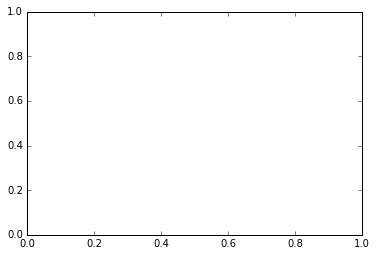

In [32]:
factor.show()

In [33]:
factor.register_node(root_node, 'phone')

In [34]:
factor.commit('factor_state2016', username)

{'_id': '67480505_2',
 '_index': 'factor_state2016',
 '_source': {'extension': [],
  'root': [['67480505', '60939648'],
   ['67480505', '70773800'],
   ['67480505', '72528621'],
   ['67480505', '59922137'],
   ['67480505', '67481273'],
   ['67480505', '44126628'],
   ['67480505', '83646104'],
   ['67480505', '51078113'],
   ['67480505', '64556658'],
   ['67480505', '44607500'],
   ['67480505', '47791826'],
   ['67480505', '54117423'],
   ['67480505', '46806447'],
   ['67480505', '54089645'],
   ['67480505', '45441361'],
   ['67480505', '73740903'],
   ['67480505', '65157649'],
   ['67480505', '71244092'],
   ['67480505', '67383704'],
   ['67480505', '54979736'],
   ['67480505', '60073673'],
   ['67480505', '43993896'],
   ['67480505', '83324239'],
   ['67480505', '44568274'],
   ['67480505', '53986830'],
   ['67480505', '57787528'],
   ['67480505', '57550824'],
   ['67480505', '73748058'],
   ['67480505', '46436362'],
   ['67480505', '47774017'],
   ['67480505', '46755404'],
   ['67480

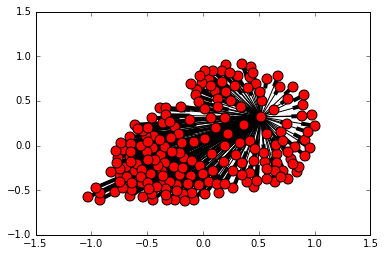

In [35]:
factor.show()

In [36]:
factor.G.adj

{'43935525': {},
 '43957618': {},
 '43986122': {},
 '43991456': {},
 '43993551': {},
 '43993896': {},
 '44005284': {},
 '44005350': {},
 '44005909': {},
 '44086702': {},
 '44098971': {},
 '44121847': {},
 '44126628': {},
 '44208079': {},
 '44347597': {},
 '44568274': {},
 '44607499': {},
 '44607500': {},
 '44607501': {},
 '44702139': {},
 '44727385': {},
 '44800054': {},
 '44835833': {},
 '44835835': {},
 '44844431': {},
 '44878711': {},
 '45178608': {},
 '45441361': {},
 '45465760': {},
 '46062573': {},
 '46094100': {},
 '46341457': {},
 '46349286': {},
 '46368914': {},
 '46392464': {},
 '46436362': {},
 '46755404': {},
 '46755409': {},
 '46755411': {},
 '46768764': {},
 '46806447': {},
 '47774017': {},
 '47791826': {},
 '47832784': {},
 '49884711': {},
 '49900775': {},
 '49939178': {},
 '51077920': {},
 '51078000': {},
 '51078004': {},
 '51078108': {},
 '51078113': {},
 '51092075': {},
 '51157571': {},
 '51162689': {},
 '51205769': {},
 '51213572': {},
 '53986830': {},
 '54089645': {

In [37]:
factor.messenger.lookup(factor.G.nodes(), 'phone')

{'5874387758', '58743877581', '6042603774'}

In [38]:
factor.messenger.suggest(factor.messenger.reverse_lookup('phone', '6042603774'), 'phone')

{'16042603774': [],
 '5145913779': ['75747201',
  '78541664',
  '79957806',
  '76127321',
  '79137561',
  '79137555',
  '79137549',
  '75747239',
  '78541630',
  '81376011',
  '82169781',
  '79958317',
  '79137493',
  '76615881',
  '75824180',
  '81648143',
  '80709595',
  '76111172',
  '83398917',
  '81361395',
  '78541656',
  '79137550',
  '81548349',
  '77391028',
  '76592947',
  '79137528',
  '79137551',
  '76742425',
  '80748122',
  '76796984',
  '76529989',
  '83373802',
  '81376226',
  '76823930',
  '76752010',
  '80709587',
  '76648366',
  '78541700',
  '81306494',
  '81346727',
  '79564931',
  '82904969',
  '78541631',
  '79137506',
  '81376209',
  '79137539',
  '76759938',
  '79137545',
  '76956519',
  '80754990',
  '76767328',
  '76918434',
  '79960569',
  '80188079',
  '78541698',
  '75635702',
  '76823945',
  '76559695',
  '76077893',
  '79567785',
  '80025529',
  '81273726',
  '76823937',
  '76664184',
  '80182571',
  '76770973',
  '79137569',
  '80589260',
  '76124972',


In [39]:
suggestions = factor.messenger.reverse_lookup('6042603774', 'phone')

In [40]:
set(suggestions) & set(factor.messenger.reverse_lookup('5874387758', 'phone'))

{'211972',
 '44044589',
 '79988669',
 '43995912',
 '54485442',
 '13120',
 '23629529',
 '58108635',
 '24815204',
 '46217574',
 '53667952',
 '28235506',
 '26470298',
 '75902104',
 '53045810',
 '62192024',
 '80270126',
 '57110634',
 '43756987',
 '27953837',
 '32065620',
 '30535804',
 '70125029',
 '23694775',
 '4806806',
 '56957262',
 '67496964',
 '30473233',
 '46294295',
 '30191244',
 '27390060',
 '54350757',
 '77035318',
 '24607296',
 '81076390',
 '28601179',
 '29675715',
 '25443613',
 '27693207',
 '74229461',
 '41298396',
 '81991330',
 '23693840',
 '25833978',
 '25418055',
 '26253916',
 '89571613',
 '34589294',
 '88639368',
 '33462963',
 '29255704',
 '74535668',
 '23999514',
 '25179747',
 '64403467',
 '54062818',
 '24305688',
 '42175603',
 '29190929',
 '29229846',
 '76768963',
 '79840602',
 '9354630',
 '53127020',
 '32406047',
 '29795119',
 '24715088',
 '49984508',
 '72281275',
 '30700209',
 '47926934',
 '42482733',
 '79183330',
 '67035824',
 '81229147',
 '27702271',
 '27764082',
 '2859

In [41]:
factor.register_node('32355127', 'phone')

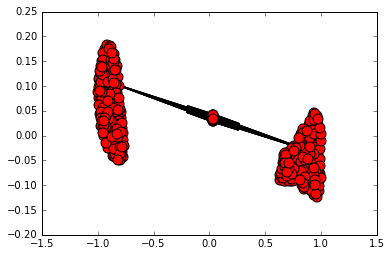

In [44]:
factor.show()

In [45]:
factor.commit('factor_state2016', username)

{'_id': '32355127_1',
 '_index': 'factor_state2016',
 '_source': {'extension': [],
  'root': [['32355127', '72916010'],
   ['32355127', '45745974'],
   ['32355127', '44607500'],
   ['32355127', '35355416'],
   ['32355127', '80939606'],
   ['32355127', '54823872'],
   ['32355127', '56787634'],
   ['32355127', '22633536'],
   ['32355127', '65828457'],
   ['32355127', '72996177'],
   ['32355127', '39747077'],
   ['32355127', '39730813'],
   ['32355127', '42139927'],
   ['32355127', '43993896'],
   ['32355127', '41337420'],
   ['32355127', '82550637'],
   ['32355127', '72664103'],
   ['32355127', '89821886'],
   ['32355127', '21122172'],
   ['32355127', '40159686'],
   ['32355127', '22607655'],
   ['32355127', '72650672'],
   ['32355127', '40158653'],
   ['32355127', '72177174'],
   ['32355127', '35339272'],
   ['32355127', '22547810'],
   ['32355127', '59047639'],
   ['32355127', '22659151'],
   ['32355127', '40890850'],
   ['32355127', '44083749'],
   ['32355127', '79366993'],
   ['32355

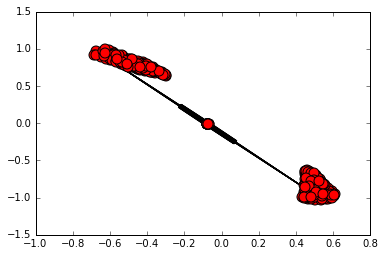

In [46]:
factor.show()

In [47]:
root_node

'67480505'

In [48]:
factor.merge('factor_state2016', username, root_node+'_1', username, root_node+'_2')

{'intersection': {('67480505', '43935525'),
  ('67480505', '43957618'),
  ('67480505', '43986122'),
  ('67480505', '43991456'),
  ('67480505', '43993551'),
  ('67480505', '43993896'),
  ('67480505', '44005284'),
  ('67480505', '44005350'),
  ('67480505', '44005909'),
  ('67480505', '44086702'),
  ('67480505', '44098971'),
  ('67480505', '44121847'),
  ('67480505', '44126628'),
  ('67480505', '44208079'),
  ('67480505', '44347597'),
  ('67480505', '44568274'),
  ('67480505', '44607499'),
  ('67480505', '44607500'),
  ('67480505', '44607501'),
  ('67480505', '44702139'),
  ('67480505', '44727385'),
  ('67480505', '44800054'),
  ('67480505', '44835833'),
  ('67480505', '44835835'),
  ('67480505', '44844431'),
  ('67480505', '44878711'),
  ('67480505', '45178608'),
  ('67480505', '45441361'),
  ('67480505', '45465760'),
  ('67480505', '46062573'),
  ('67480505', '46094100'),
  ('67480505', '46341457'),
  ('67480505', '46349286'),
  ('67480505', '46368914'),
  ('67480505', '46392464'),
  ('

# Looking at Elasticsearch

In [49]:
es = connections.get_connection('local')

In [50]:
response = Search(es).query().execute()

In [51]:
[i['_source'] for i in response.hits.hits]

[{'extension': [],
  'root': [['32355127', '33440848'],
   ['32355127', '75120918'],
   ['32355127', '73615784'],
   ['32355127', '54823872'],
   ['32355127', '35403367'],
   ['32355127', '52969428'],
   ['32355127', '80209175'],
   ['32355127', '40890850'],
   ['32355127', '37498759'],
   ['32355127', '31439187'],
   ['32355127', '37963605'],
   ['32355127', '59210356'],
   ['32355127', '68185237'],
   ['32355127', '72957937'],
   ['32355127', '41540450'],
   ['32355127', '39747077'],
   ['32355127', '64335693'],
   ['32355127', '63299276'],
   ['32355127', '54401129'],
   ['32355127', '35355416'],
   ['32355127', '79415391'],
   ['32355127', '43991456'],
   ['32355127', '43890382'],
   ['32355127', '58346587'],
   ['32355127', '39603220'],
   ['32355127', '45745979'],
   ['32355127', '72141854'],
   ['32355127', '36044679'],
   ['32355127', '37311876'],
   ['32355127', '46349286'],
   ['32355127', '68776890'],
   ['32355127', '80347204'],
   ['32355127', '82538970'],
   ['32355127', 